# Aspect-Based Sentiment Analysis with BERT

In this notebook we turn a pre-trained BERT model into a trainable Keras layer. BERT (Bidirectional Embedding Representations from Transformers) is a new model for pre-training language representations that obtains state-of-the-art results on many NLP tasks. We demonstrate how to integrate BERT as a custom Keras layer to simplify model prototyping using huggingface.

In [2]:
import keras
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt

from keras.layers import LSTM, RNN, Dropout, Input, LeakyReLU, Bidirectional,Conv1D, GlobalMaxPooling1D
from keras.layers.core import Dense
from keras.models import Model


Before start, we should install the huggingface transformer package. You can find the doc from its [website](https://huggingface.co/transformers/index.html).

In [3]:
pip install transformers

     |████████████████████████████████| 4.0 MB 5.4 MB/s 
     |████████████████████████████████| 596 kB 44.0 MB/s 
     |████████████████████████████████| 895 kB 45.4 MB/s 
     |████████████████████████████████| 77 kB 6.3 MB/s 
     |████████████████████████████████| 6.6 MB 42.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


## Preprocessing and Tokenization

In this lab we will use DistilBERT instead of BERT: DistilBERT is a small, fast, cheap and light Transformer model trained by distilling BERT base. It has 40% less parameters than bert-base-uncased, and runs 60% faster, while preserving over 95% of BERT’s performance as measured on the GLUE language understanding benchmark.

It is easy to switch between DistilBERT and BERT using the huggingface transformer package. This huggingface package provides many pre-trained and pre-built models that are easy to use via a few lines of code.

Before using DistilBERT or BERT, we need a tokenizer. Generally speaking, every BERT related model has its own tokenizer, trained for that model (see this week's lecture video on sub-word tokenization). 
We can get the DistilBERT tokenizer from **DistilBertTokenizer.from_pretrained** function.

In [4]:
from transformers import DistilBertTokenizer, RobertaTokenizer 
import tqdm
distil_bert = 'distilbert-base-uncased' # Pick any desired pre-trained model

# Defining DistilBERT tokonizer
tokenizer = DistilBertTokenizer.from_pretrained(distil_bert, do_lower_case=True, add_special_tokens=True,
                                                max_length=128, pad_to_max_length=True)

def tokenize(sentences, tokenizer, pad_length=128, pad_to_max_length=True ):
    if type(sentences) == str:
        inputs = tokenizer.encode_plus(sentences, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        return np.asarray(inputs['input_ids'], dtype='int32'), np.asarray(inputs['attention_mask'], dtype='int32'), np.asarray(inputs['token_type_ids'], dtype='int32')
        
    input_ids, input_masks, input_segments = [],[],[]
    for sentence in sentences:
        inputs = tokenizer.encode_plus(sentence, add_special_tokens=True, max_length=pad_length, pad_to_max_length=pad_to_max_length, 
                                             return_attention_mask=True, return_token_type_ids=True)
        input_ids.append(inputs['input_ids'])
        input_masks.append(inputs['attention_mask'])
        input_segments.append(inputs['token_type_ids'])        
        
    return np.asarray(input_ids, dtype='int32'), np.asarray(input_masks, dtype='int32'), np.asarray(input_segments, dtype='int32')


Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Then we can use the tokenizer to tokenize the sentence. When working with word2vec and GloVe, we tokenized the sentence into words ourselves and then converted the tokens to GloVe word indices. But in BERT, we must use the BERT tokenizer: the tokens for BERT are different, and include whole words and sub-word tokens (see lecture video on sub-word tokenisation).

For example, for the sentence: **This is a pretrained model.** our previous word-based tokenizer will generate the following tokens:

**"this", "is", "a", "pretrained", "model", "."**

Then you will find out that the word token "pretrained" is not in the GloVe word dictionary. Thus we can not assign a proper word vector for "pretrained".

In BERT, the BERT tokenizer will separate the word "pretrained" into three sub-word tokens:

**'pre', '##train', '##ed'**

This way, BERT can use these three token vectors to represent the word "pretrained". Without the BERT tokenizer, it is hard to separate these unknown words properly.

You will also see that the BERT tokenizer adds the special sentence [CLS] token and sentence separator [SEP] tokens (see this week's lecture videos).

In [5]:
inputs = tokenizer.tokenize("The capital of France is [MASK].")
print(inputs,'\n')

inputs = tokenizer.tokenize("This is a pretrained model.")
print(inputs,'\n')



ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer)
print("ids: ",ids)
print("masks: ,",masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")
print("segments: ",segments)
print()

ids,masks,segments = tokenize("The capital of France is [MASK].", tokenizer, pad_to_max_length=False)
print(ids)
print(masks)
print(tokenizer.convert_ids_to_tokens(ids),"\n")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


['the', 'capital', 'of', 'france', 'is', '[MASK]', '.'] 

['this', 'is', 'a', 'pre', '##train', '##ed', 'model', '.'] 

ids:  [ 101 1996 3007 1997 2605 2003  103 1012  102    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
masks: , [1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


## Loading Data

### Downloading and preprocessing data

Similar to lab 4, we need to download and preprocess the data first. The data download code is consistent with lab 4.

In [6]:
import requests
def downloadfile(url):
  rq = requests.get(url)
  open(url.split('/')[-1], 'wb').write(rq.content)
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/train.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/val.xml')
downloadfile('https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data/MAMS-ATSA/raw/test.xml')


# The code is modified from https://raw.githubusercontent.com/siat-nlp/MAMS-for-ABSA/master/data_process/utils.py
from xml.etree.ElementTree import parse

def parse_sentence_term(path, lowercase=False):
    tree = parse(path)
    sentences = tree.getroot()
    data = []
    split_char = '__split__'
    for sentence in sentences:
        text = sentence.find('text')
        if text is None:
            continue
        text = text.text
        if lowercase:
            text = text.lower()
        aspectTerms = sentence.find('aspectTerms')
        if aspectTerms is None:
            continue
        for aspectTerm in aspectTerms:
            term = aspectTerm.get('term')
            if lowercase:
                term = term.lower()
            polarity = aspectTerm.get('polarity')
            start = aspectTerm.get('from')
            end = aspectTerm.get('to')
            piece = [text , term,  polarity , start , end]
            data.append(piece)
    return data
train = parse_sentence_term("train.xml",True)
dev = parse_sentence_term("val.xml",True)
test = parse_sentence_term("test.xml",True)

print("Training entries: {}".format(len(train)))
print("Test entries: {}".format(len(test)))


Training entries: 11186
Test entries: 1336


We now can start playing around with the data, let’s first see some examples:

In [7]:
print("SENTENCE \t ASPECT \t LABLE \t ASPECT-START-INDEX \t ASPECT-END-INDEX")
print(train[0])
print(train[1])
print(train[2])
print(train[3])
print(train[4])

SENTENCE 	 ASPECT 	 LABLE 	 ASPECT-START-INDEX 	 ASPECT-END-INDEX
['the decor is not special at all but their food and amazing prices make up for it.', 'decor', 'negative', '4', '9']
['the decor is not special at all but their food and amazing prices make up for it.', 'food', 'positive', '42', '46']
['the decor is not special at all but their food and amazing prices make up for it.', 'prices', 'positive', '59', '65']
['when tables opened up, the manager sat another party before us.', 'tables', 'neutral', '5', '11']
['when tables opened up, the manager sat another party before us.', 'manager', 'negative', '27', '34']


According to the BERT tokenize function above, we can convert the tweet text and topic words to integers:

(Note: the BERT tokenize function is different from lab 4.)


### Function that would give data needed to train and evaluate

In [8]:
def int_masks(dataset):
    """
    This function for each dataset would produce sentence and aspect ids(sentence_int and aspect_int) and will also produce
    sentence_masks and aspect_masks.
    
    The function will first create 4 empty list called sentence_int, sentence_masks, aspect_int and aspect_masks. Then for each
    instance in our dataset, we pass the sentence(i[0]) of that instance to the above defined function called tokenize which
    produce sent_ids, sent_masks and sent_segments. Then we append sentence_ids to the empty list sentence_int and we append 
    sent_masks to the empty list sentence masks.
    
    We perform the same steps to obtain aspect_int and aspect_masks, instead of passing sentence we pass aspect of the instance
    to the tokenizer function defined above.
    
    At the end the function will return sentence_int, sentence_masks, aspect_int, aspect_masks for each instance of our dataset
    
    Note that padding to max_length(128) is set to True by default
    """
    sentence_int =[]
    sentence_masks = []
    aspect_int=[]
    aspect_masks=[]
    for i in dataset:
      sent_ids,sent_masks,sent_segments = tokenize(i[0], tokenizer) # i[0] here is the sentence
      aspect_ids, aspect_m, aspect_segments = tokenize(i[1], tokenizer) # i[1] here is the aspect

      sentence_int.append(sent_ids) # list appended to the empty above
      sentence_masks.append(sent_masks)

      aspect_int.append(aspect_ids)
      aspect_masks.append(aspect_m)

    return sentence_int, sentence_masks, aspect_int, aspect_masks


# sanity check
x_train_review_int, x_train_review_masks, x_train_aspect_int, x_train_aspect_masks = int_masks(train)

print(x_train_review_int[0]) 

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[  101  1996 25545  2003  2025  2569  2012  2035  2021  2037  2833  1998
  6429  7597  2191  2039  2005  2009  1012   102     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]


In [9]:
# Please write your code to generate the following data
x_train_review_int, x_train_review_masks, x_train_aspect_int, x_train_aspect_masks = int_masks(train)

x_dev_review_int,x_dev_review_masks, x_dev_aspect_int,x_dev_aspect_masks = int_masks(dev)


x_test_review_int, x_test_review_masks, x_test_aspect_int, x_test_aspect_masks = int_masks(test)


#######################TODO: REMOVE FOLLOWING CODE####################


#######################TODO: REMOVE ABOVE CODE####################


# If use the previous tokenize function, you can get a print result like:
assert len(x_train_aspect_int) == len(train)
assert len(x_train_aspect_masks) == len(x_train_aspect_int)
assert len(x_test_aspect_int) == len(test)
assert len(x_test_aspect_masks) == len(x_test_aspect_int)
print("x_dev_aspect_int[0]:")
print(x_dev_aspect_int[0])
print("x_dev_aspect_masks[0]:")
print(x_dev_aspect_masks[0])
print("x_dev_review_int[0]:")
print(x_dev_review_int[0])
print("x_dev_review_masks[0]:")
print(x_dev_review_masks[0])

/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


x_dev_aspect_int[0]:
[ 101 8974  102    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
x_dev_aspect_masks[0]:
[1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
x_dev_review_int[0]:
[  101  2044  1037  323

We one-hot encode the labels, using 4 (Binary:100) to represent "positive", 2 (Binary:010) for "neutral", and 1 (Binary:001) for "negative". Then we can convert the labels to numbers.

In [10]:
def label2int(dataset):
  y = []
  for example in dataset:
    if example[2].lower() == "negative":
      y.append([0,0,1])
    elif example[2].lower() == "neutral":
      y.append([0,1,0])
    else:
      # assert example[2].lower() == "positive"
      y.append([1,0,0])
  return y
  
y_train = label2int(train)
y_dev = label2int(dev)
y_test = label2int(test)
y_train = np.array(y_train)
y_dev = np.array(y_dev)
y_test = np.array(y_test)

print(y_train[0])
print(y_train[1])
print(y_train[2])
print(y_train[3])
print(y_train[4])

[0 0 1]
[1 0 0]
[1 0 0]
[0 1 0]
[0 0 1]


Now we have almost done the data preprocessing. Unlike the previous lab1-lab4, there are two x (review and aspect) to input the model. The easiest way is to combine the review and aspect into one sentence and then input it into the model. Thus we can use the previous model directly.

In [11]:
def int_masks_2(dataset):
    """
    This function is similar to function we used above called int_masks, the only difference is we pass the list, which has
    sentence and review combined with "[SEP]" token in between them, to the tokenize function.
    
    In the sentence of each instance of the dataet, we first add "[SEP]" to the sentence string and then we add review.
    
    We then pass this string containing sentence,"[SEP]",and review to the tokenize function which will produce sent_ids and
    sent_masks. We then append sent_ids to the empty list sentence_int and we append sent_masks to the empty list sentence_masks.
    """
    sentence_int =[]
    sentence_masks = []
    
    for i in dataset:
      # review_aspect is of form
      #'the decor is not special at all but their food and amazing prices make up for it. [SEP] decor'
      review_aspect = i[0] + " [SEP] " + i[1] 
      sent_ids,sent_masks,sent_segments = tokenize(review_aspect, tokenizer)
      
      sentence_int.append(sent_ids)
      sentence_masks.append(sent_masks)

    return sentence_int, sentence_masks


In [12]:
# Please write your code to combine the tweet and topic into the following varibles
# x_train_int
# x_train_masks
# x_dev_int
# x_dev_masks
# x_test_int
# x_test_masks

x_train_int, x_train_masks = int_masks_2(train)

x_dev_int, x_dev_masks = int_masks_2(dev)


x_test_int, x_test_masks = int_masks_2(test)


# Tips: 
# 1) We can use the special token <SEP> to concatenate the tweets and topics.
# 2) After combine them, make sure they are paded.

#######################TODO: REMOVE FOLLOWING CODE####################


#######################TODO: REMOVE ABOVE CODE####################

# Don't forget the to use np.array function to wrap the ouput of pad_sequences function
x_train_int_np = np.array(x_train_int)
x_train_masks_np = np.array(x_train_masks)
x_dev_int_np = np.array(x_dev_int)
x_dev_masks_np = np.array(x_dev_masks)
x_test_int_np = np.array(x_test_int)
x_test_masks_np = np.array(x_test_masks)


print(x_dev_int[0])
print(x_dev_masks[0],'\n')
print(x_dev_int_np[0])
print(x_dev_masks_np[0]) # senetnce + aspect


/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


[  101  2044  1037  3232  1997  8974  1010  1996 18726  1011  1011  1045
  2066  1996 27940  1013 24792  2621  4897  1998  1996 13675 11514  6508
 26852  1011  1011  2175  2091  2307  1012   102  8974   102     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Model 1: Prebuilt Sequence Classification



The huggingface transformer package provides many prebuilt models. Now let us try a sequence classification model based on distillBERT. 

The models with BERT are much bigger than our previous models. To run it faster, we can use TPU here. The detailed guideline about using TPU can be found from https://www.tensorflow.org/guide/tpu.

In [13]:
from transformers import TFDistilBertForSequenceClassification, DistilBertConfig
import tensorflow as tf

distil_bert = 'distilbert-base-uncased'

config = DistilBertConfig(num_labels=3)
config.output_hidden_states = False

def create_TFDistilBertForSequenceClassification():
  transformer_model = TFDistilBertForSequenceClassification.from_pretrained(distil_bert, config = config)
  input_ids = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_ids = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32')
  X = transformer_model(input_ids, input_masks_ids)
  return tf.keras.Model(inputs=[input_ids, input_masks_ids], outputs = X)

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model on TPU:
  with strategy.scope():
    model = create_TFDistilBertForSequenceClassification()
    optimizer = tf.keras.optimizers.Adam(lr=5e-5)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model = create_TFDistilBertForSequenceClassification()
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.103.202.210:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.103.202.210:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Downloading:   0%|          | 0.00/347M [00:00<?, ?B/s]

Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertForSequenceClassification: ['activation_13', 'vocab_layer_norm', 'vocab_projector', 'vocab_transform']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['dropout_19', 'pre_classifier', 'classifier']
You should probably TRAIN this model on a down-stream task to be able to use i

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_for_sequence_cl  TFSequenceClassifie  66955779   ['input_token[0][0]',            
 assification (TFDistilBertForS  rOutput(loss=None,               'masked_token[0][0]']           
 equenceClassification)         logits=(None, 3),                                                 
                                 hidden_states=None                                           

In [15]:
history1 = model.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 102s 2s/step - loss: 0.8923 - accuracy: 0.3978 - val_loss: 0.6044 - val_accuracy: 0.4535
Epoch 2/30
22/22 [==============================] - 5s 215ms/step - loss: 0.6007 - accuracy: 0.4543 - val_loss: 0.5782 - val_accuracy: 0.4640
Epoch 3/30
22/22 [==============================] - 5s 216ms/step - loss: 0.5751 - accuracy: 0.4833 - val_loss: 0.5710 - val_accuracy: 0.5135
Epoch 4/30
22/22 [==============================] - 5s 217ms/step - loss: 0.5586 - accuracy: 0.5078 - val_loss: 0.5408 - val_accuracy: 0.5308
Epoch 5/30
22/22 [==============================] - 5s 216ms/step - loss: 0.5763 - accuracy: 0.4970 - val_loss: 0.5644 - val_accuracy: 0.5233
Epoch 6/30
22/22 [==============================] - 5s 215ms/step - loss: 0.5300 - accuracy: 0.5800 - val_loss: 0.4936 - val_accuracy: 0.6426
Epoch 7/30
22/22 [==============================] - 5s 220ms/step - loss: 0.4496 - accuracy: 0.6950 - val_loss: 0.4185 - val_accuracy: 0.7432
Epoch 8

In [16]:
results1 = model.evaluate([x_test_int_np,x_test_masks_np], y_test)
print("Loss: ",results1[0], "and", "Accuracy: ",results1[1])

42/42 [==============================] - 8s 98ms/step - loss: 0.8413 - accuracy: 0.8024
Loss:  0.8413050770759583 and Accuracy:  0.802395224571228


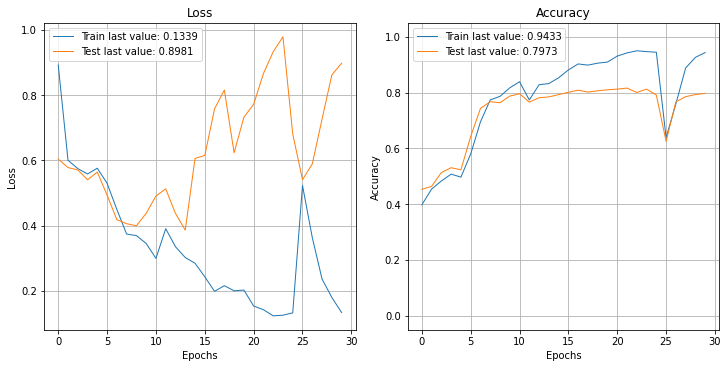

In [17]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history1.history, path="standard.png")
plt.show()


## Model 2: Neural bag of words using BERT

We use model3-1 from lab4 to integrate BERT, using BERT instead of the previous static word embeddings.


In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

In [ ]:
from transformers import TFDistilBertModel, DistilBertConfig

def get_BERT_layer():
  distil_bert = 'distilbert-base-uncased'
  config = DistilBertConfig(dropout=0.2, attention_dropout=0.2)
  config.output_hidden_states = False
  return TFDistilBertModel.from_pretrained(distil_bert, config = config)


In [ ]:
import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]

  pooled_sent=GlobalAveragePooling1DMasked()(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(pooled_sent) # Sigmoid
  label=Dense(3,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model2_NBOW_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model2 = create_bag_of_words_BERT()
    optimizer2 = tf.keras.optimizers.Adam(lr=5e-5)
    model2.compile(optimizer=optimizer2, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model2 = create_bag_of_words_BERT()
  model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model2.summary() 




INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.69.247.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.247.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model2_NBOW_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model (TFDistil  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 BertModel)                     ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

history2 = model2.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 110s 3s/step - loss: 0.6341 - accuracy: 0.4543 - val_loss: 0.5860 - val_accuracy: 0.4767
Epoch 2/30
22/22 [==============================] - 5s 226ms/step - loss: 0.5704 - accuracy: 0.5263 - val_loss: 0.5347 - val_accuracy: 0.6216
Epoch 3/30
22/22 [==============================] - 6s 266ms/step - loss: 0.5237 - accuracy: 0.6421 - val_loss: 0.5116 - val_accuracy: 0.6719
Epoch 4/30
22/22 [==============================] - 5s 234ms/step - loss: 0.4963 - accuracy: 0.6904 - val_loss: 0.4925 - val_accuracy: 0.7020
Epoch 5/30
22/22 [==============================] - 5s 238ms/step - loss: 0.4708 - accuracy: 0.7361 - val_loss: 0.4573 - val_accuracy: 0.7688
Epoch 6/30
22/22 [==============================] - 5s 229ms/step - loss: 0.4415 - accuracy: 0.7943 - val_loss: 0.4517 - val_accuracy: 0.7823
Epoch 7/30
22/22 [==============================] - 5s 226ms/step - loss: 0.4161 - accuracy: 0.8354 - val_loss: 0.4374 - val_accuracy: 0.7995
Epoch 8

In [ ]:
results2 = model2.evaluate([x_test_int_np,x_test_masks_np], y_test)
print("Loss: ",results2[0], "and", "Accuracy: ",results2[1])

42/42 [==============================] - 8s 106ms/step - loss: 0.4068 - accuracy: 0.8219
Loss:  0.4067635238170624 and Accuracy:  0.8218563199043274


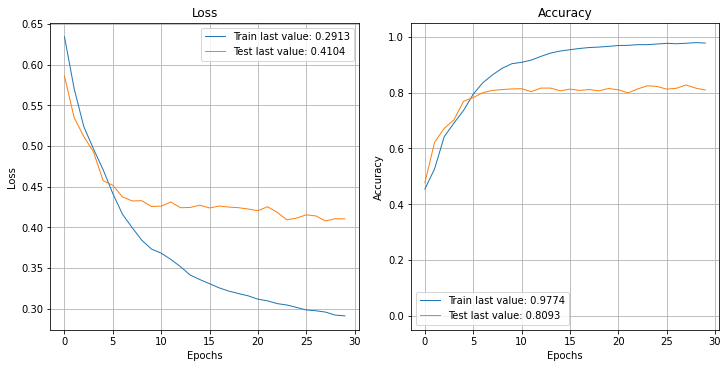

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history2.history, path="standard.png")
plt.show()

* In Lab4 we tried various models without pre-trained embeddings and also with pre-trained embeddings. All the models that we tried gave the accuracy of in range of around 56% to 65% but when we used BERT the accuracy jumped to around 80%. <br><br>

* Also note that in lab4 we added sentence to aspect i.e. in the input aspect was first followed by sentence whereas in lab8 it is vice-versa.<br><br>

* In Lab4, using GloVe embeddings for NBOW model we obtained accuracy of around 56% , for CNN we obtained accuracy of around 63% and for LSTM we obtained poor accuracy of around 45%, whereas in lab8 using BERT embeddings the accuracies for every model improved very significantly to around 83%. <br><br>

* Also note that in lab4 using GloVe embedding we received very poor accuracy for LSTM and the reason was the post-padding. LSTM remembers the past data and output, adding 0’s at the end resulted in the deterioration of model performance but adding BERT embeddings improved the LSTM performance significantly. 


## Model 3: LSTM with BERT

Please follow the same methods as model2 to construct a CNN or LSTM model on top of BERT.

In [ ]:
# your code goes here

import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]


  lstm = LSTM(100, return_sequences=False)(embedded_sent)
  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(lstm) # Sigmoid
  label=Dense(3,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model3_LSTM_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model3 = create_bag_of_words_BERT()
    optimizer = tf.keras.optimizers.Adam(lr=5e-5)
    model3.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model3 = create_bag_of_words_BERT()
  model3.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model3.summary() 


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.69.247.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.247.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model3_LSTM_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

history3 = model3.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 124s 3s/step - loss: 0.6459 - accuracy: 0.4341 - val_loss: 0.5982 - val_accuracy: 0.5173
Epoch 2/30
22/22 [==============================] - 7s 300ms/step - loss: 0.5801 - accuracy: 0.5493 - val_loss: 0.5398 - val_accuracy: 0.6577
Epoch 3/30
22/22 [==============================] - 7s 299ms/step - loss: 0.5197 - accuracy: 0.6969 - val_loss: 0.4854 - val_accuracy: 0.7628
Epoch 4/30
22/22 [==============================] - 6s 294ms/step - loss: 0.4691 - accuracy: 0.7836 - val_loss: 0.4689 - val_accuracy: 0.7785
Epoch 5/30
22/22 [==============================] - 7s 297ms/step - loss: 0.4388 - accuracy: 0.8267 - val_loss: 0.4468 - val_accuracy: 0.8026
Epoch 6/30
22/22 [==============================] - 7s 298ms/step - loss: 0.4148 - accuracy: 0.8600 - val_loss: 0.4494 - val_accuracy: 0.7860
Epoch 7/30
22/22 [==============================] - 7s 302ms/step - loss: 0.4017 - accuracy: 0.8743 - val_loss: 0.4363 - val_accuracy: 0.8093
Epoch 8

In [ ]:
results3 = model3.evaluate([x_test_int_np,x_test_masks_np], y_test)
print("Loss: ",results3[0], "and", "Accuracy: ",results3[1])

42/42 [==============================] - 10s 118ms/step - loss: 0.3983 - accuracy: 0.8271
Loss:  0.39831238985061646 and Accuracy:  0.8270958662033081


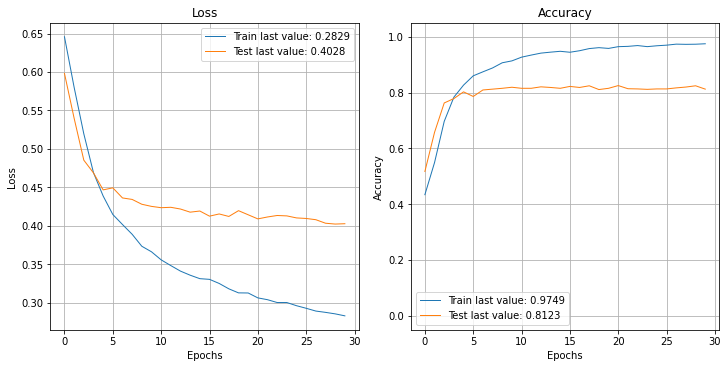

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history3.history, path="standard.png")
plt.show()

### CNN WITH BERT

In [ ]:
# your code goes here

import tensorflow as tf
hdepth=16
MAX_SEQUENCE_LENGTH = 128
EMBED_SIZE=100


def create_bag_of_words_BERT():
  input_ids_in = tf.keras.layers.Input(shape=(128,), name='input_token', dtype='int32')
  input_masks_in = tf.keras.layers.Input(shape=(128,), name='masked_token', dtype='int32') 

  bert_embeddings = get_BERT_layer()
  embedded_sent = bert_embeddings(input_ids_in, attention_mask=input_masks_in)[0]
  conv1d = Conv1D(filters = 100, kernel_size=6,padding = "valid")(embedded_sent)
  max_pool = GlobalMaxPooling1D()(conv1d)

  hidden_output=Dense(hdepth,input_shape=(MAX_SEQUENCE_LENGTH,EMBED_SIZE),activation='sigmoid',kernel_initializer='glorot_uniform')(max_pool) # Sigmoid
  label=Dense(3,input_shape=(hdepth,),activation='softmax',kernel_initializer='glorot_uniform')(hidden_output)
  return Model(inputs=[input_ids_in,input_masks_in], outputs=[label],name='Model_CNN_BERT')

use_tpu = True
if use_tpu:
  # Create distribution strategy
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
  tf.config.experimental_connect_to_cluster(tpu)
  tf.tpu.experimental.initialize_tpu_system(tpu)
  strategy = tf.distribute.experimental.TPUStrategy(tpu)

  # Create model
  with strategy.scope():
    model_cnn = create_bag_of_words_BERT()
    optimizer = tf.keras.optimizers.Adam(lr=5e-5)
    model_cnn.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
else:
  model_cnn = create_bag_of_words_BERT()
  model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model_cnn.summary() 


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: grpc://10.69.247.50:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.69.247.50:8470


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)
Some layers from the model checkpoint at distilbert-base-uncased were not used when initializing TFDistilBertModel: ['vocab_transform', 'vocab_projector', 'activation_13', 'vocab_layer_norm']
- This IS expected if you are initializing TFDistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFDistilBertModel were initialized from the model checkpoint at distilbert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertMo

Model: "Model_CNN_BERT"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_token (InputLayer)       [(None, 128)]        0           []                               
                                                                                                  
 masked_token (InputLayer)      [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_2 (TFDist  TFBaseModelOutput(l  66362880   ['input_token[0][0]',            
 ilBertModel)                   ast_hidden_state=(N               'masked_token[0][0]']           
                                one, 128, 768),                                                   
                                 hidden_states=None                                  

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:

history_cnn = model_cnn.fit([x_train_int_np,x_train_masks_np],
                    y_train,
                    epochs=30,
                    batch_size=512,
                    validation_data=([x_dev_int_np,x_dev_masks_np], y_dev),
                    verbose=1)

Epoch 1/30
22/22 [==============================] - 113s 3s/step - loss: 0.6568 - accuracy: 0.3509 - val_loss: 0.6138 - val_accuracy: 0.4580
Epoch 2/30
22/22 [==============================] - 5s 234ms/step - loss: 0.6064 - accuracy: 0.4600 - val_loss: 0.5918 - val_accuracy: 0.5788
Epoch 3/30
22/22 [==============================] - 5s 226ms/step - loss: 0.5778 - accuracy: 0.5849 - val_loss: 0.5602 - val_accuracy: 0.6381
Epoch 4/30
22/22 [==============================] - 5s 226ms/step - loss: 0.5497 - accuracy: 0.6493 - val_loss: 0.5464 - val_accuracy: 0.6441
Epoch 5/30
22/22 [==============================] - 5s 224ms/step - loss: 0.5321 - accuracy: 0.6810 - val_loss: 0.5356 - val_accuracy: 0.6959
Epoch 6/30
22/22 [==============================] - 5s 227ms/step - loss: 0.5214 - accuracy: 0.7098 - val_loss: 0.5250 - val_accuracy: 0.7050
Epoch 7/30
22/22 [==============================] - 6s 294ms/step - loss: 0.4972 - accuracy: 0.7569 - val_loss: 0.5056 - val_accuracy: 0.7327
Epoch 8

In [ ]:
results_cnn = model_cnn.evaluate([x_test_int_np,x_test_masks_np], y_test)
print("Loss: ",results_cnn[0], "and", "Accuracy: ",results_cnn[1])

42/42 [==============================] - 8s 104ms/step - loss: 0.4473 - accuracy: 0.8278
Loss:  0.44730597734451294 and Accuracy:  0.8278443217277527


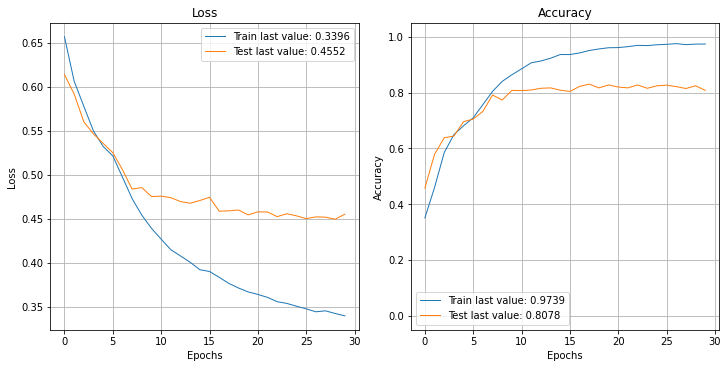

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt
plot_history(history_cnn.history, path="standard.png")
plt.show()

* Using BERT embeddings we constructed, trained, and tested LSTM and CNN models. Using LSTM along with BERT embeddings gave similar accuracy to what we achieved with CNN model along with BERT embedding, but in lab4 LSTM performed quite poorly compared to NBOW and CNN along with GloVe embeddings. Comparing to task 2 we can see that although there is not significant difference but the LSTM and CNN model with BERT embeddings performed better than the pre-built sequence classification model. The accuracies for NBOW, LSTM and CNN using BERT embeddings are very much similar. <br><br>

* Looking at the plots we can see that the loss converged at a steady rate and accuracy remained same after reaching the 10th epoch for all 3 models. In terms of parameters, NBOW has 66375235 parameters, LSTM has 66712147 parameters and CNN model has 668255447 parameters. 
